https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import optuna
from reprpo.hp.helpers import optuna_df
from reprpo.training import train
from reprpo.experiments import experiment_configs
from reprpo.hp.space import search_spaces
from optuna.study.study import storages, get_all_study_names
from reprpo.hp.helpers import get_params, get_optuna_df


[2024-10-08 21:11:00,685] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = 4,2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from reprpo.hp.target import override, default_tuner_kwargs
from reprpo.experiments import experiment_configs
import copy

## Objective

In [6]:
SEED=42
key_metric = "acc_gain_vs_ref/oos"

In [7]:
f_db = f"sqlite:///optuna.db"
f = f_db.replace('sqlite:///', './')
print(f)
Path(f).parent.mkdir(parents=True, exist_ok=True)
f_db

./optuna.db


'sqlite:///optuna.db'

## Opt

Note on pruning. It's only really usefull with validation metrics and for long jobs over many epochs. I've got a small proxy job so there is no need.

In [8]:
def plot_param_importances(study, key_metric):
    df_res = get_optuna_df(study, key_metric)
    df2 = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)

    # plot_param_importances(study)
    # plt.show()

    for i in range(len(df_res)):
        row = df_res.iloc[i]
        param = row.name
        best = row.best
        x = f"params_{param}"
        hue = df2[x].apply(lambda x: x == best)
        if row.dist=='categorical':
            p = sns.catplot(data=df2, x=x, y="value", kind="boxen", 
                        #height=3, 
                        height=2, aspect=3,
                        legend=False,
                        hue=hue)
        else:
            plt.figure(figsize=(6, 2))
            sns.scatterplot(data=df2, x=x, y='value', hue=hue, alpha=0.5, ax=plt.gca())
            sns.scatterplot(data=df2[hue], x=x, y='value', ax=plt.gca(), marker='x', color='red', s=100)
            # TODO if it's a log dist make log
        plt.legend('off').remove()
        plt.title(f"{param} i={row.importance:2.2g} best={best}")
        plt.xlabel(None)
        # plt.ylabel(key_metric)
        plt.show()

In [27]:
df

,number,value,datetime_start,datetime_complete,duration,params_lr,params_mag_clip,params_mag_clip_value,params_neg_slope,params_neg_slope_value,params_reverse_pref,params_scale_orth,params_weight_dim,params_β,state
0,0,1.048170,2024-10-07 15:34:15.481901,2024-10-07 15:37:41.320138,0 days 00:03:25.838237,7.459343e-06,None,NaN,0,NaN,True,True,0,0.950714,COMPLETE
1,1,0.416185,2024-10-07 15:37:41.894153,2024-10-07 15:41:06.343417,0 days 00:03:24.449264,7.072114e-03,None,NaN,0,NaN,True,False,1,0.832443,COMPLETE
2,2,1.044316,2024-10-07 15:41:06.938149,2024-10-07 15:44:26.360124,0 days 00:03:19.421975,2.888838e-06,None,NaN,float,0.948886,False,False,1,0.366362,COMPLETE
3,3,0.491329,2024-10-07 15:44:26.914958,2024-10-07 15:47:46.043679,0 days 00:03:19.128721,6.732249e-03,None,NaN,0,NaN,True,True,0,0.808397,COMPLETE
4,4,1.134875,2024-10-07 15:47:46.647078,2024-10-07 15:51:10.881928,0 days 00:03:24.234850,2.054052e-04,float,0.033959,0,NaN,False,False,2,0.311711,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,142,1.200385,2024-10-08 21:19:30.232264,2024-10-08 21:22:53.105947,0 days 00:03:22.873683,2.875502e-04,float,553.480842,0,NaN,True,False,0,0.874410,COMPLETE
143,143,0.992293,2024-10-08 21:22:53.722179,2024-10-08 21:26:13.980097,0 days 00:03:20.257918,4.670164e-04,float,4.253839,0,NaN,True,False,0,0.912256,COMPLETE
144,144,1.086705,2024-10-08 21:26:14.593358,2024-10-08 21:29:33.083326,0 days 00:03:18.489968,3.089890e-04,float,531.695811,0,NaN,True,False,0,0.872733,COMPLETE
145,145,0.963391,2024-10-08 21:29:33.699698,2024-10-08 21:32:53.190015,0 days 00:03:19.490317,3.843538e-04,float,51.979424,0,NaN,True,False,0,0.816308,COMPLETE


In [26]:

study_names = get_all_study_names(storage=f_db)
res = {}
for study_name in study_names:
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        v = study.best_trial.values[0]
        df_res2 = optuna_df(study, key_metric)

        df = study.trials_dataframe()
        n_c = len(df.query('state == "COMPLETE"'))
        n = len(df)
        res[study_name] = dict(n_trials=n, best=v, n_trials_completed=n_c)
        # round just the numeric rows
        # print(df_res2.to_markdown())
        df_res2 = df_res2.applymap(lambda x: float(f"{x:2.4g}") if isinstance(x, (float,)) else x)
        print(df_res2.to_markdown())
        print()
    except ValueError as e:
        pass

df_res = pd.DataFrame(res).T.sort_values('best', ascending=False)
print(df_res.to_markdown())

| side-ether-prefvec N=✓208/209, best=1.169   |   importance | best      |
|:--------------------------------------------|-------------:|:----------|
| β                                           |        0.288 | 0.4038    |
| Htype                                       |        0.163 | oft       |
| lr                                          |        0.145 | 0.0006154 |
| use_angle_loss                              |        0.141 | True      |
| use_dpo_loss                                |        0.122 | False     |
| weight_tokens                               |        0.031 | False     |
| use_nll_loss                                |        0.028 | False     |
| nb                                          |        0.027 | 30        |
| use_orth_loss                               |        0.017 | False     |
| collect_input                               |        0.011 | False     |
| collect_hs                                  |        0.011 | False     |
| flip_side              

In [25]:
df_res = pd.DataFrame(res).T.sort_values('best', ascending=False)
print(df_res.to_markdown())

|                    |   n |    best |   completed |
|:-------------------|----:|--------:|------------:|
| projgrad3          | 146 | 1.27938 |         145 |
| dpo                | 210 | 1.27553 |         208 |
| side-hra-rank      | 183 | 1.22929 |         182 |
| ether-prefvec      | 266 | 1.18304 |         261 |
| side-ether-prefvec | 209 | 1.16923 |         208 |
| hs-ortho-prefvec   | 261 | 1.15222 |         259 |
| hs-hra-rank        | 262 | 1.15222 |         259 |
| projbp             | 283 | 1.05973 |         147 |
| hs-svd-mse         | 332 | 1.01727 |          14 |
| side-svd-mse       | 316 | 1.00962 |          28 |


## plots

projgrad2


[W 2024-10-08 21:11:54,518] Study instance does not contain completed trials.


,importance,best
"projgrad2 N=✓0/315, best=nan",,


[W 2024-10-08 21:11:54,698] Study instance does not contain completed trials.


-
side-ether-prefvec


,importance,best
"side-ether-prefvec N=✓208/209, best=1.169",,
β,0.240,0.403787
use_dpo_loss,0.171,False
use_angle_loss,0.168,True
lr,0.125,0.000615
Htype,0.090,oft
weight_tokens,0.084,False
collect_input,0.043,False
nb,0.025,30
use_orth_loss,0.017,False


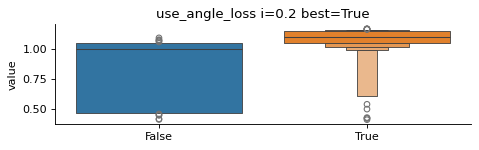

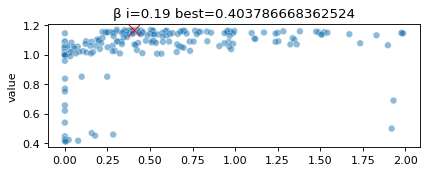

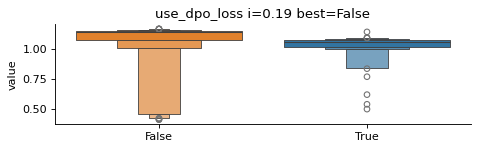

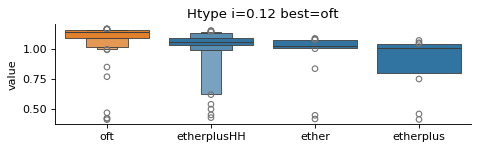

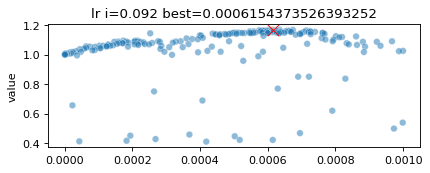

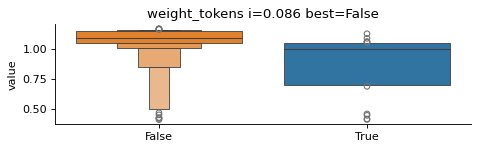

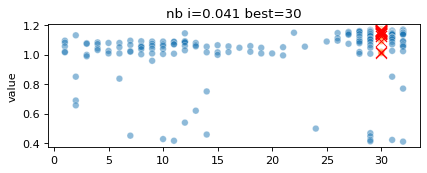

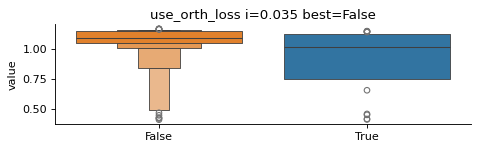

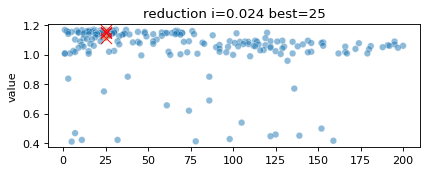

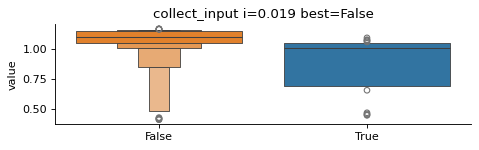

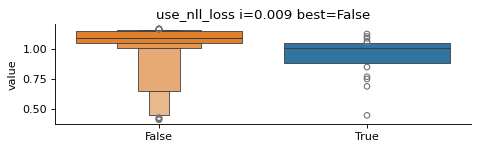

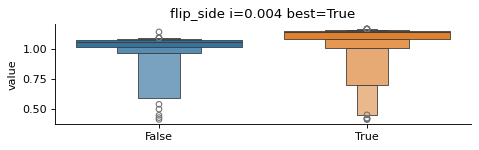

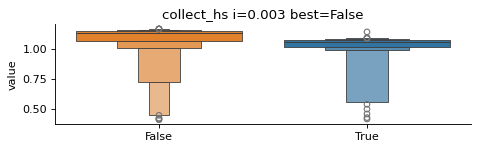

projgrad


[W 2024-10-08 21:12:00,876] Study instance does not contain completed trials.


,importance,best
"projgrad N=✓0/4, best=nan",,


[W 2024-10-08 21:12:00,973] Study instance does not contain completed trials.


-
side-svd-mse


,importance,best
"side-svd-mse N=✓28/316, best=1.010",,
lr,0.977,0.001195
α,0.021,0.635584
quantile,0.001,float
collect_hs,0.000,True
dual_svd,0.000,True
collect_input,0.000,False
quantile_value,NaN,0.3


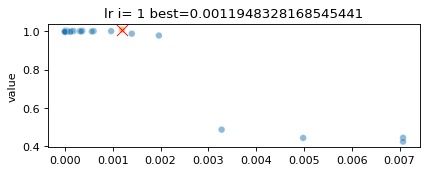

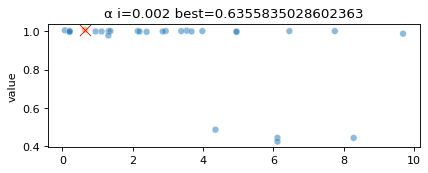

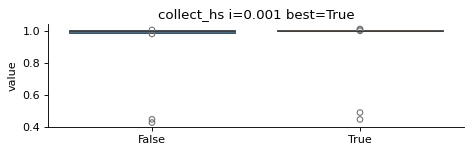

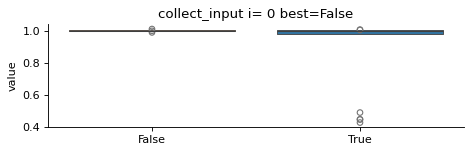

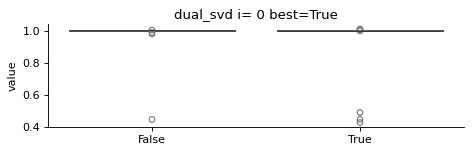

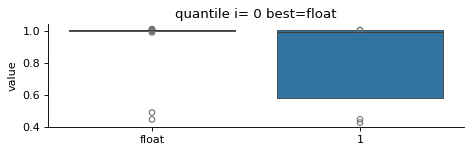

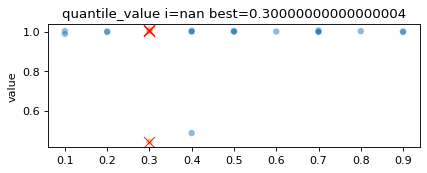

side-hra-rank


,importance,best
"side-hra-rank N=✓182/183, best=1.229",,
lr,0.900,0.000188
collect_input,0.053,False
collect_hs,0.043,False
β,0.002,0.110393
apply_GS,0.001,False
r,0.001,2
α,0.000,5.920778


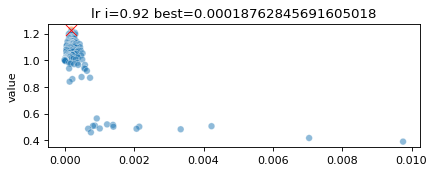

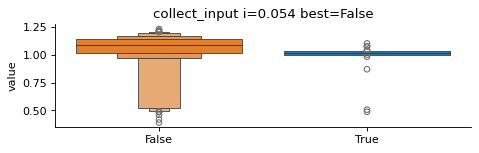

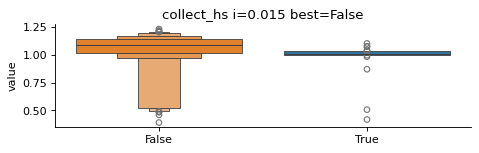

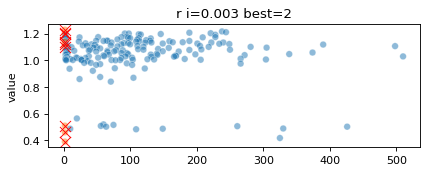

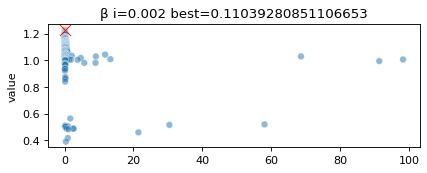

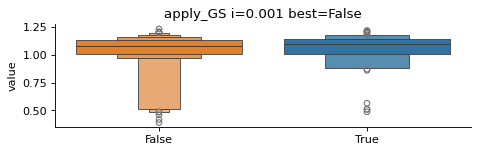

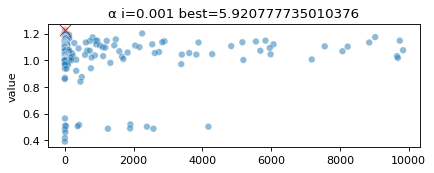

hs-ortho-prefvec


,importance,best
"hs-ortho-prefvec N=✓259/261, best=1.152",,
lr,0.957,0.000411
β,0.017,1.970152
use_angle_loss,0.012,True
use_nll_loss,0.004,True
use_proj_rel,0.003,True
use_orth_loss,0.003,True
orthogonal_map,0.002,matrix_exp
weight_tokens,0.002,False
use_dpo_loss,0.001,False


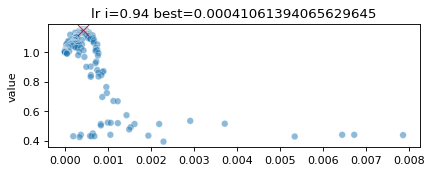

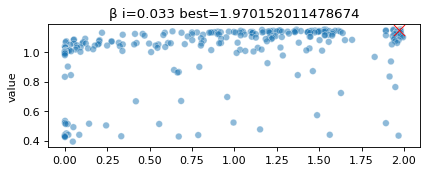

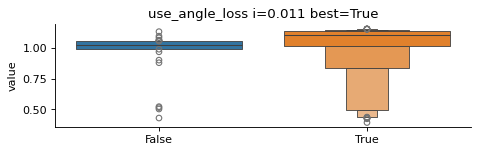

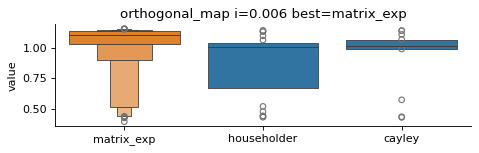

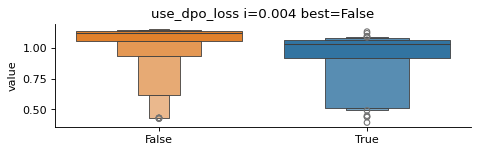

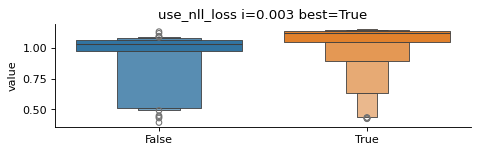

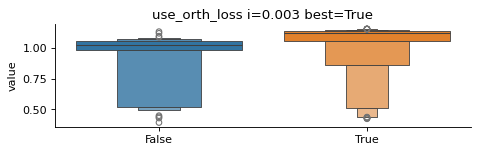

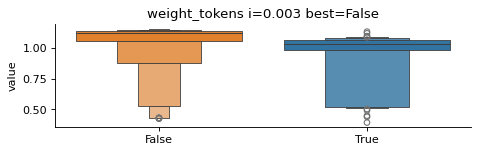

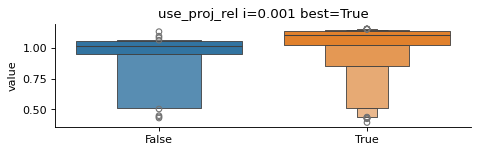

projbp


,importance,best
"projbp N=✓147/283, best=1.060",,
scale_orth,0.408,False
β,0.339,0.850002
lr,0.220,0.000005
neg_slope,0.029,float
mag_clip,0.002,None
reverse_pref,0.001,True
neg_slope_value,NaN,0.42073


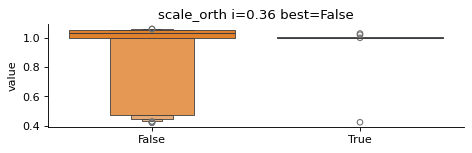

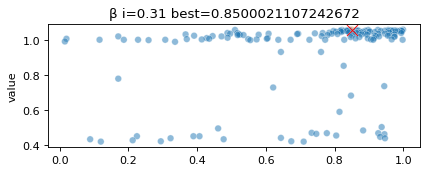

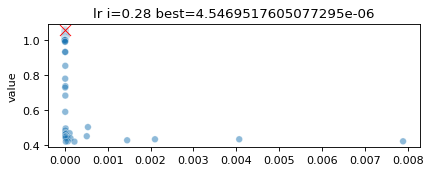

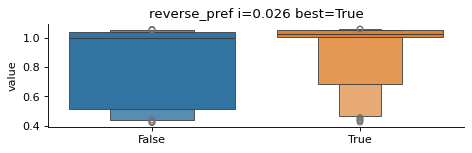

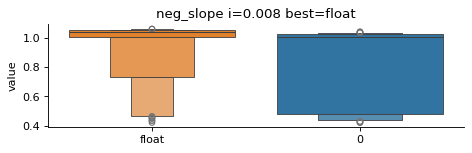

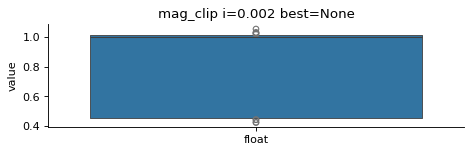

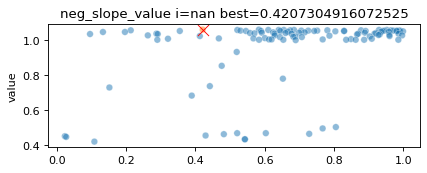

dpo


,importance,best
"dpo N=✓208/210, best=1.276",,
lr,1.0,0.000265


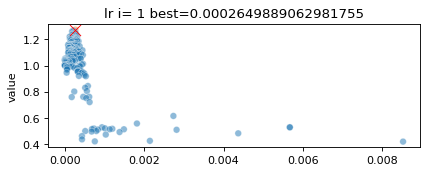

hs-svd-mse


,importance,best
"hs-svd-mse N=✓14/332, best=1.017",,
lr,0.892,0.001195
α,0.084,0.635584
dual_svd,0.023,True
collect_input,0.000,False
collect_hs,0.000,True
quantile,0.000,float
quantile_value,NaN,0.3


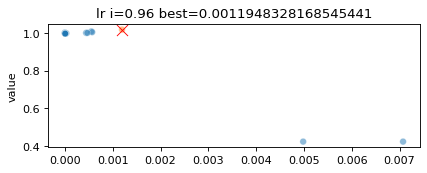

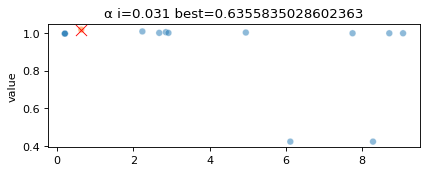

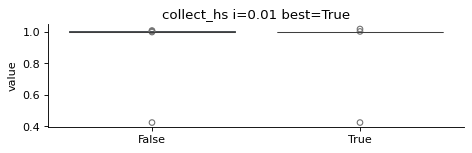

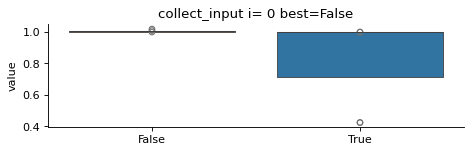

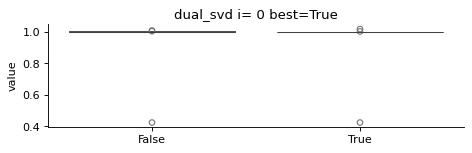

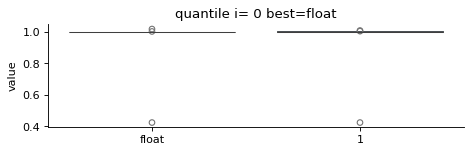

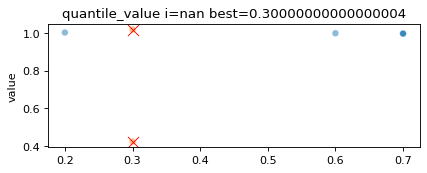

hs-hra-rank


,importance,best
"hs-hra-rank N=✓259/262, best=1.152",,
lr,0.808,0.000333
β,0.101,0.37992
r,0.079,38
apply_GS,0.012,True
α,0.000,0.280164


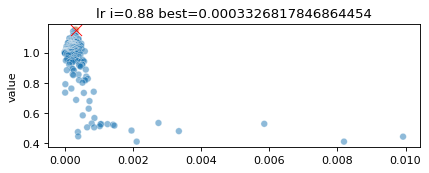

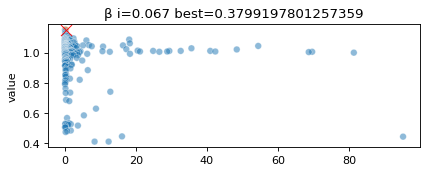

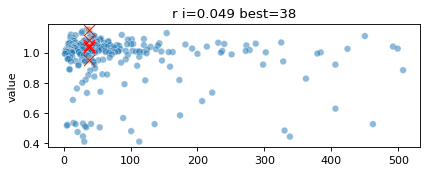

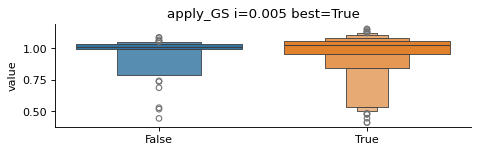

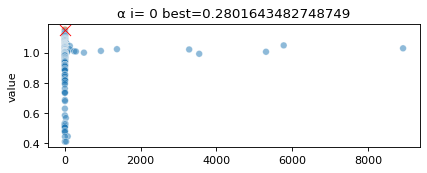

ether-prefvec


,importance,best
"ether-prefvec N=✓261/266, best=1.183",,
lr,0.826,0.000378
β,0.061,1.984854
reduction,0.040,1
nb,0.021,20
use_angle_loss,0.014,True
use_proj_rel,0.012,True
collect_hs,0.007,False
Htype,0.005,ether
use_orth_loss,0.005,True


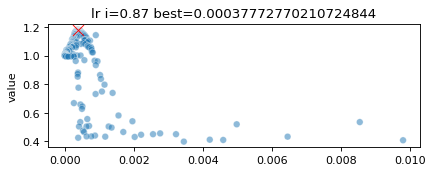

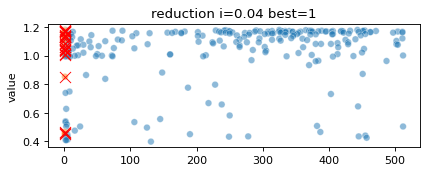

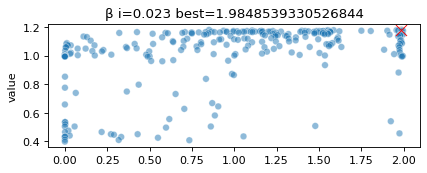

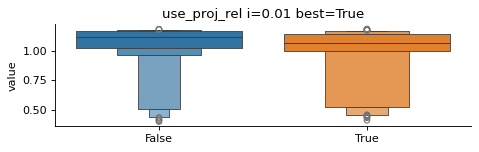

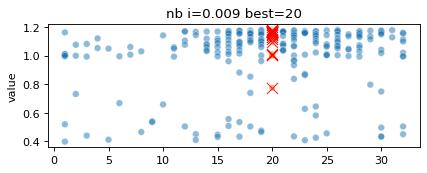

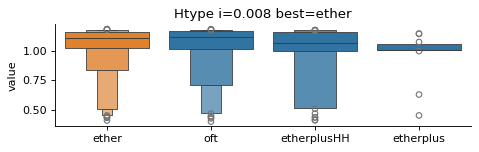

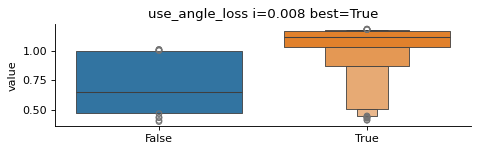

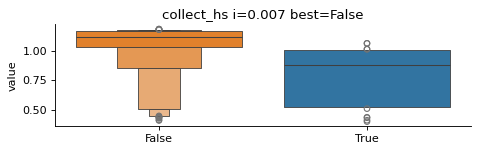

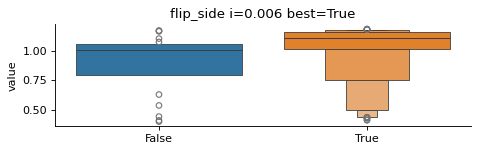

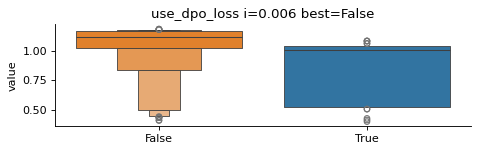

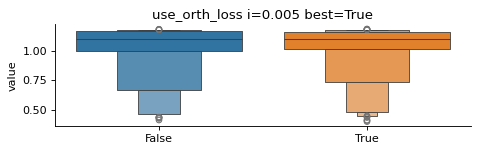

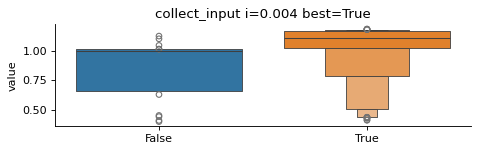

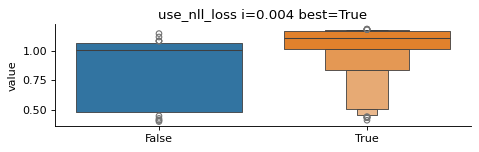

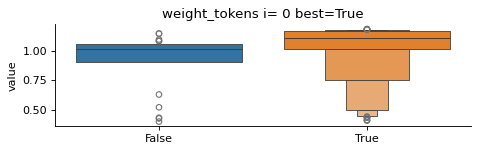

projgrad3


,importance,best
"projgrad3 N=✓140/141, best=1.279",,
lr,0.892,0.000232
β,0.075,0.842679
weight_dim,0.020,1
scale_orth,0.006,False
reverse_pref,0.004,True
mag_clip,0.001,float
neg_slope,0.001,0
mag_clip_value,NaN,0.230096


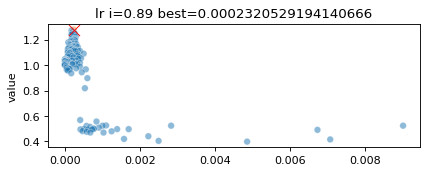

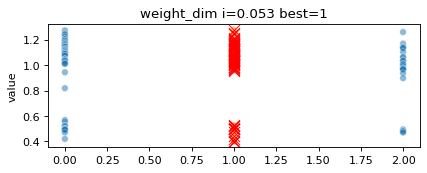

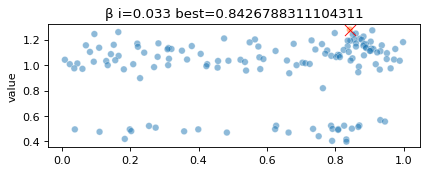

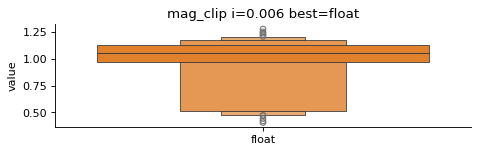

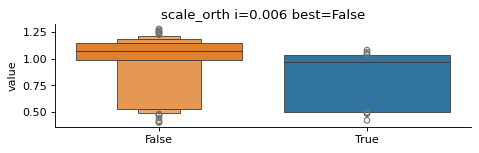

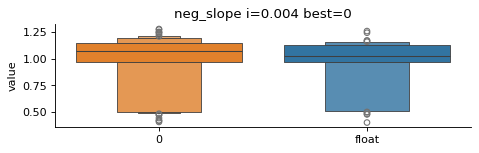

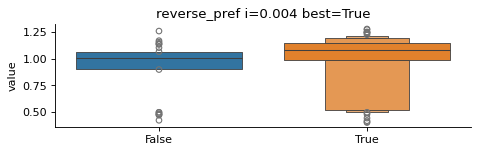

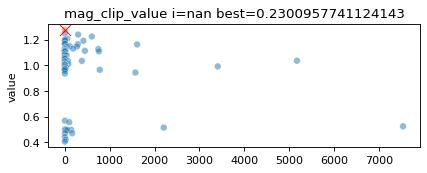

In [9]:

study_names = get_all_study_names(storage=f_db)

for study_name in study_names:
    print(study_name)
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        df_res2 = optuna_df(study, key_metric)
        display(df_res2)
        plot_param_importances(study, key_metric)
        # print()
    except ValueError as e:
        print('-')
    print('='*80)

In [10]:
df_res = get_optuna_df(study, key_metric)
df_res

,dist,importance,best
lr,float,0.931,0.000232
β,float,0.028,0.842679
weight_dim,int,0.020,1
scale_orth,categorical,0.010,False
mag_clip,categorical,0.005,float
neg_slope,categorical,0.003,0
reverse_pref,categorical,0.003,True
mag_clip_value,NaN,NaN,0.230096
